<a href="https://colab.research.google.com/github/aguilin1/tda_ai_text_generation/blob/main/tda_ai_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/aguilin1/tda_ai_text_generation.git
!pip install nltk
!pip install Ripser
!pip install gudhi

Cloning into 'tda_ai_text_generation'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 249 (delta 51), reused 0 (delta 0), pack-reused 123 (from 2)
Receiving objects: 100% (249/249), 38.73 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (107/107), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.7 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=948292e02c492f94d34aa958791b29442cf3d9bd8083e117d00bfb011e199d02
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.0 MB/s eta 0:00:00


In [2]:
# set up Ripser for use (run this just once)

from ripser import ripser, Rips
from persim import plot_diagrams
import gudhi as gd

In [3]:
# Functions ---
# cosSimDistanceMatrix: creates cosine similarity distance matrix
# vrFiltration: takes a distance matrix and computes Vietoris-Rips filtration

from sklearn.metrics.pairwise import cosine_similarity
import itertools
import warnings
from scipy.sparse import SparseEfficiencyWarning
import numpy as np
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def smoothing(embeddings):
  number_sentences = embeddings.shape[0]
  original_embeddings = embeddings.copy()
  for i in range(number_sentences):
    smoothed = original_embeddings[safe_index(i -3, number_sentences)]/8.0 +\
      original_embeddings[safe_index(i -2, number_sentences)]/4.0 + \
      original_embeddings[safe_index(i -1, number_sentences)]/2.0 + \
      original_embeddings[i] + \
      original_embeddings[safe_index(i +1, number_sentences)]/2.0 + \
      original_embeddings[safe_index(i +2, number_sentences)]/4.0 + \
      original_embeddings[safe_index(i +3, number_sentences)]/8.0
    embeddings[i] = smoothed
  return embeddings

def safe_index(i, total_n):
  if i < 0:
    return i * -1
  elif i >= total_n-1:
    return total_n -1 - (i % total_n)
  else:
    return i

def angular_distance(embeddings, index_1, index_2):
  cos_sim = cosine_similarity(embeddings[index_1].reshape(1, -1),\
                              embeddings[index_2].reshape(1, -1))[0][0]

  dist = 2 * np.arccos(cos_sim) / np.pi
  if np.isnan(dist):
    # If we've gotten here it's likely the precision needed to differentiate is more than a float can handle
    dist = 0.0
  return dist

# input a single array of embeddings
def angular_distance_matrix(embeddings, time_skeleton = False):
  # get # of data points in each sample
  n_dpts = embeddings.shape[0]
  # preallocate distance matrix
  angular_distances = np.zeros((n_dpts, n_dpts))
  # Label each data point in order starting at 0, 1, 2, ...
  # Distance between data point i and data point j is in (i,j) entry of matrix
  # Matrix will be upper triangular
  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      dist = angular_distance(embeddings, pair1_i, pair2_i)
    angular_distances[pair1_i][pair2_i] = dist
    angular_distances[pair2_i][pair1_i] = dist
  return angular_distances


def mixed_distance_matrix(bow_embeddings, bert_embeddings, alpha, time_skeleton = False):
  # This should align with the tokens (number of sentences), so match between types
  n_dpts = bert_embeddings.shape[0]

  cosSimDistances = np.zeros((n_dpts, n_dpts))

  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      distance_bow = angular_distance(bow_embeddings, pair1_i, pair2_i)
      distance_bert = angular_distance(bert_embeddings, pair1_i, pair2_i)
      dist = alpha * distance_bow + (1 - alpha) * distance_bert

    cosSimDistances[pair1_i][pair2_i] = dist
    cosSimDistances[pair2_i][pair1_i] = dist
  return cosSimDistances

# input a symmetric distance matrix and this function will return birth and
# death homology data for the V-R complex
def ripserFiltration(distanceMat, maxDim=3):
  # Here's one way to use Ripser
  # examples and instructions are here:
  # https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
  # https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix

  # This version uses the distance matrix input, which is what we want
  #plotDistanceHistogram(distanceMat)
  birthDeathPairs = ripser(distanceMat, distance_matrix=True, maxdim=maxDim, do_cocycles=True)['dgms']

  # diagrams is a vector of vectors where each element of each
  # vector is [birth epoch, death epoch] and the vectors are in increasing order
  # of homology (H0, H1, H2, etc.).
  return birthDeathPairs

def plotDistanceHistogram(distmatrix):
  # Flatten the matrix to get all data in a single array
  data = [x for x in distmatrix.flatten() if x != 0]
  # Create the histogram
  plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
  # Add titles and labels
  plt.title('Histogram of Distances')
  plt.xlabel('Distance')
  plt.ylabel('Frequency')
  # Show the plot
  plt.show()
  # we need a way to figure out which metric was used for this plot

In [4]:
import numpy as np
import itertools
import csv
# import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sys
np.set_printoptions(threshold=sys.maxsize)

class Simplex(frozenset):
    def __str__(self):
        return ",".join(str(item) for item in self)

    def __repr__(self):
        return f"({', '.join(repr(item) for item in self)})"

    def __or__(self, other):
        return Simplex(super().__or__(other))

    def union(self, *others):
        return Simplex(super().union(*others))

    def __and__(self, other):
        return Simplex(super().__and__(other))

    def intersection(self, *others):
        return Simplex(super().intersection(*others))

    def __sub__(self, other):
        return Simplex(super().__sub__(other))

    def difference(self, *others):
        return Simplex(super().difference(*others))

    def __xor__(self, other):
        return Simplex(super().__xor__(other))

    def symmetric_difference(self, other):
        return Simplex(super().symmetric_difference(other))

    def dimension(self):
        return len(self)

def simplicies(data):
    points = set(itertools.chain.from_iterable(data))
    p = points.copy()
    complexes_by_distance = {
        0.0: set([Simplex([a]) for a in p])
    }
    for simplex, distance in data.items():
      if distance not in complexes_by_distance:
          complexes_by_distance[distance] = set()
      complexes_by_distance[distance].add(simplex)

    # 3 dimension: triangles where the edges are all within the given distance
    for v1,v2,v3 in itertools.combinations(p, 3):
        edges = [Simplex(x) for x in itertools.combinations([v1, v2, v3], 2)]
        distance = max(data[edge] for edge in edges)
        complexes_by_distance[distance].add(Simplex([v1, v2, v3]))

    # 4 dimension: tetrahedra where edges are all within the given distance
    for v1,v2,v3,v4 in itertools.combinations(points, 4):
        edges = [Simplex(x) for x in itertools.combinations([v1, v2, v3, v4], 2)]
        distance = max(data[edge] for edge in edges)
        complexes_by_distance[distance].add(Simplex([v1, v2, v3, v4]))

    return complexes_by_distance

def filtration(distances, max_distance, debug = False):
    homologies_births = {}
    homologies_per_epic = {}

    # print("\t Computing simplices")
    simplices_by_distance = simplicies(distances)
    # Add the zero homologies to the first epic by default
    for points in distances.keys():
        for point in points:
            homologies_births[Simplex([point])] = 0
    homologies_per_epic[0] = set(homologies_births.keys()) | simplices_by_distance[0.0]

    if max_distance == 'inf':
        max_distance = max(distances.values())

    birth_deaths = []

    for current_distance_filter in sorted(distances.values()):
        if current_distance_filter > max_distance:
            break

        new_in_epic = simplices_by_distance[current_distance_filter]
        homologies_per_epic[current_distance_filter] = new_in_epic

        for item in new_in_epic:
            homologies_births[item] = current_distance_filter

    sorted_simplices = matrix_sorted_values(homologies_per_epic, current_distance_filter)
    # print("\t Getting matrix for algorithm")
    matrix = evaluation_matrix(sorted_simplices)

    if debug:
        print(sorted_simplices)
        debug_matrix = reconstruct_matrix(matrix)
        print(debug_matrix)
        print(np.count_nonzero(np.matmul(debug_matrix,debug_matrix) % 2))

    # print("\t Running persistence algorithm")
    deaths, homologies, pivots, chain_members = evaluate(matrix, sorted_simplices)

    if debug:
        debug_matrix = reconstruct_matrix(matrix)
        print(debug_matrix)

    birth_deaths_by_dim = {i: [] for i in range(4)}
    for death, killed_by in deaths.items():
        birth = homologies_births.pop(death, None)
        death_epic = homologies_births[killed_by]

        index = sorted_simplices.index(death)
        birth_deaths.append((homologies[index], birth, death_epic))

        homology = homologies[index]
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        birth_deaths_by_dim[dimension].append([birth, death_epic])

    still_living = []
    for still_living_homology, birth in homologies_births.items():
        if still_living_homology in chain_members:
            continue
        still_living.append((still_living_homology, birth, None))
        homology = still_living_homology
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        birth_deaths_by_dim[dimension].append([birth, np.inf])

    return birth_deaths, still_living, current_distance_filter, {i: np.array(p) for i,p in birth_deaths_by_dim.items()}

# Filtrations sorted within each epic for use as rows/columns of our matrix
def matrix_sorted_values(filtration_by_epic, current_epic):
    sorted_by_epic = []
    for epic in sorted(filtration_by_epic.keys()):
        homologies = filtration_by_epic[epic]
        if len(homologies) > 0:
            sorted_by_epic += sorted(homologies, key = lambda homology: homology.dimension())

    return sorted_by_epic

# Since this is very sparse we're not really making a matrix, but one can be reconstructed
# from the hash output here
def evaluation_matrix(sorted_filtration):
    index_lookup = {h: i for i, h in enumerate(sorted_filtration)}
    matrix = {}

    for j, complex in enumerate(sorted_filtration):
        if complex.dimension() == 1:
            continue
        for member in complex:
            boundary = complex ^ Simplex([member])
            i = index_lookup[boundary]
            if j in matrix:
                matrix[j].add(i)
            else:
                matrix[j] = set([i])
    return matrix

def reconstruct_matrix(matrix_base):
    n = max(matrix_base.keys()) + 1
    matrix = np.zeros((n,n), dtype=np.int8)

    for col, row_markers in matrix_base.items():
        for row in row_markers:
            matrix[row, col] = 1

    return matrix

def evaluate(matrix, orig_values):
    deaths = {}
    pivot_to_column = {}
    values = {i: {homology} for i, homology in enumerate(orig_values)}

    members_of_chain = set()
    for column in range(len(orig_values)+1):
        while True:
            if column in matrix.keys():
                column_row_nonzeros_indices = matrix[column]
                if len(column_row_nonzeros_indices) == 0:
                    break

                lowest_nonzero = max(column_row_nonzeros_indices)
                if lowest_nonzero in pivot_to_column.keys():
                    previous_pivot_column = pivot_to_column[lowest_nonzero]
                    previous_pivot_row = matrix[previous_pivot_column]
                    matrix[column] = column_row_nonzeros_indices ^ previous_pivot_row
                    values[column].update(values[previous_pivot_column])
                else:
                    pivot_to_column[lowest_nonzero] = column
                    for val in values[lowest_nonzero]:
                        if val != orig_values[lowest_nonzero]:
                            members_of_chain.add(val)
                    deaths[orig_values[lowest_nonzero]] = orig_values[column]
                    break
            else:
                break

    return deaths, values, pivot_to_column, members_of_chain

In [5]:
import pickle

def load_cached_embeddings(abstract_type, embedding_type, num_abstracts):
  DATA_FILE_BASE = '/content/tda_ai_text_generation/data/{}_encodings_{}-{}.pkl'

  bow_data = DATA_FILE_BASE.format('bow', abstract_type, 0)

  if embedding_type == 'bert':
    batch_sentences = []
    batch_embeddings = []
    for i in range(0,num_abstracts,100):
      i += 1
      bert_data = DATA_FILE_BASE.format('sentence-bert', abstract_type, i)
      with open(bert_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences += cache_data['sentences']
        batch_embeddings += cache_data['embeddings']
  elif embedding_type == 'bow':
    with open(bow_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  return batch_sentences, batch_embeddings

In [6]:
def plot_persistence_diagram_a(births_deaths, still_living, max_epic):
    plt.figure(figsize=(6, 6))

    colors = {
        0: 'r',
        1: 'y',
        2: 'g',
        3: 'b',
        4: 'c'
    }
    seen_dim = set()

    infinity_val = max_epic * 1.09

    for persistence in births_deaths + still_living:
        homology = persistence[0]
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        birth = persistence[1]
        death = persistence[2]
        if death is None:
            death = infinity_val
        if dimension in seen_dim:
            label = None
        else:
            label = "H{}".format(dimension)
            seen_dim.add(dimension)
        plt.scatter(birth, death, c=colors[dimension], label=label)

    graph_edge = max_epic * 1.1
    plt.plot([0, graph_edge], [0, graph_edge], color='gray', linestyle='--')
    plt.axhline(y=infinity_val, color='gray', linestyle='--')

    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.title("Persistence Diagram")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, graph_edge)
    plt.ylim(0, max_epic*1.2)
    plt.show()


def plot_persistence_diagram_b(births_deaths, still_living, max_epic):
    colors = {
        0: 'purple',
        1: 'cornflowerblue',
        2: 'green',
        3: 'yellow'
    }

    seen_dim = set()
    infinity_val = max_epic * 1.09
    graph_edge = max_epic * 1.1

    data = []

    for persistence in births_deaths + still_living:
        homology = persistence[0]
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        if dimension > 2:
            continue
        birth = persistence[1]
        death = persistence[2] if persistence[2] is not None else infinity_val
        # if birth == death:
        #     continue

        label = f"H{dimension}" if dimension not in seen_dim else None
        seen_dim.add(dimension)

        data.append(go.Scatter(
            x=[birth],
            y=[death],
            mode='markers',
            marker=dict(color=colors.get(dimension, 'black'), size=8),
            name=label if label else f"H{dimension}",
            showlegend=(label is not None),
            text=str(homology)
        ))

    data.append(go.Scatter(
        x=[0, graph_edge],
        y=[0, graph_edge],
        mode='lines',
        line=dict(color='gray', dash='dash'),
        name='Diagonal'
    ))

    data.append(go.Scatter(
        x=[0, graph_edge],
        y=[infinity_val, infinity_val],
        mode='lines',
        line=dict(color='gray', dash='dash'),
        name='Infinity'
    ))

    layout = go.Layout(
        title=f"Persistence Diagram",
        xaxis=dict(title='Birth', range=[0, graph_edge]),
        yaxis=dict(title='Death', range=[0, infinity_val * 1.1]),
        legend=dict(itemsizing='constant'),
        width=600,
        height=600
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
[(9, 2), (28, 2), (56, 2)]


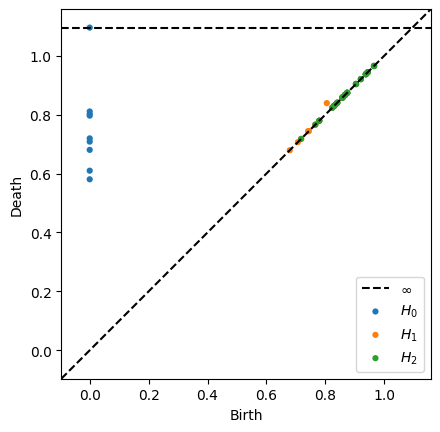

In [7]:
def distances(embeddings, time_skeleton):
    distances = {}
    for pair1, pair2 in itertools.combinations(range(embeddings.shape[0]), 2):
      if (pair1 == pair2 + 1 or pair1 == pair2 - 1) and time_skeleton:
        dist = 0
      else:
        dist = angular_distance(embeddings, pair1, pair2)
      distances[Simplex([pair1, pair2])] = dist
    return distances

_, batch_embeddings = load_cached_embeddings('ai', 'bow', 10)
d = distances(batch_embeddings[0], False)

birth_deaths, still_living, max_epic, dims = filtration(d, 'inf')
plot_persistence_diagram_b(birth_deaths, still_living, max_epic)

rips = Rips()
print([a.shape for a in list(dims.values())[:-1]])
rips.plot(list(dims.values())[:-1])

d = distances(batch_embeddings[0], True)

birth_deaths, still_living, max_epic, dims = filtration(d, 'inf')
plot_persistence_diagram_b(birth_deaths, still_living, max_epic)


In [17]:
import pickle
import numpy as np
import copy
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS

def diagram_sizes(dgms):
    return {f"H_{i}": len([p for p in d if p[0] != p[1]]) for i, d in enumerate(dgms)}

def print_sizes(sizes, num_abstracts):
  num_h0 = 0
  num_h1 = 0
  num_h2 = 0
  for size in sizes:
    num_h0 += size['H_0']
    num_h1 += size['H_1']
    num_h2 += size['H_2']

  print("|H0|: {} |H1|: {} |H2|: {}".format(num_h0/num_abstracts, num_h1/num_abstracts, num_h2/num_abstracts))

# replace with should be multiplied by the max, right? 1.1 could be anywhere in the diagram?
def replace_infinity(diagrams, replace_with = 1.1):
  for diagram in diagrams:
    for point in diagram:
      if point[1] == np.inf:
        point[1] = replace_with
  return diagrams

# Eli: it might be better to just remove inf points; I think that Persistence Images were designed that way based on the paper.
def remove_infinity(diagram):
  for dim in range(len(diagram)):
    if len(diagram[dim]) > 0:
      diagram[dim] = diagram[dim][~np.any(diagram[dim] == np.inf, axis=1)]
  return diagram

def run_evaluation(abstract_type, embedding_type, time_skeleton = False, with_smoothing = False, graph = False, num_abstracts = 100, filtration_type = 'vr'):
  _, batch_embeddings = load_cached_embeddings(abstract_type, embedding_type, num_abstracts)

  # initialize diagram arrays
  diagrams_h0 = []
  diagrams_h1 = []
  diagrams_h2 = []

  rips = Rips()
  persistence_diagrams = []
  sizes = []
  description = "{} text encoded with {}".format(abstract_type, embedding_type.upper())
  if time_skeleton:
    description += " with time skeleton"
  if with_smoothing:
    description += " smoothed"
  if filtration_type == 'alpha':
    description += " using alpha filtration"
  if graph:
    num_abstracts = 3
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
    title = "Persistence diagram for {}".format(description)
    fig.suptitle(title)
    subplot = 0
  else:
    print(description)

  for i, embeddings in enumerate(batch_embeddings[0:num_abstracts]):
    if embeddings.shape[0] < 5:
      continue
    if with_smoothing:
      embeddings = smoothing(embeddings)

    if filtration_type == 'alpha':
      D = angular_distance_matrix(embeddings, time_skeleton)
      embedding_scaled = MDS(n_components = 4, dissimilarity = 'precomputed')
      X_transformed = embedding_scaled.fit_transform(D)
      diagram = gd.AlphaComplex(points=X_transformed).create_simplex_tree().persistence()
      by_dimension = {}
      for p in diagram:
        if p[0] not in by_dimension:
          by_dimension[p[0]] = []
        by_dimension[p[0]].append(p[1:][0])
      diagram = [np.array(p) for p in by_dimension.values()]
      diagram.reverse()
    else:
      d = distances(embeddings, time_skeleton)
      birth_deaths, still_living, max_epic, bd = filtration(d, 'inf')
      diagram = list(bd.values())

    # distances = angular_distance_matrix(embeddings, time_skeleton)
    # diagram = ripserFiltration(distances)
    persistence_diagrams.append(diagram)
    sizes.append(diagram_sizes(diagram))
    # instantiate PeristanceImager to use in plotting
    pimgr = PersistenceImager(pixel_size=0.05)
    # pimgr.fit(replace_infinity(diagram))

    if graph:
      # print(replace_infinity(diagram[1])[0])
      # imgs = pimgr.transform(replace_infinity(diagram[1])[0])
      # pimgr.plot_image(imgs[0], axs[1][subplot])
      rips.plot(diagram[:-1], show=False, ax=axs[subplot])
      subplot += 1

    # For each new diagram, append its points to the the appropriate array. These must have all infs removed or replaced.
    #diagram_infResolved = replace_infinity(diagram)
    diagram_infResolved = remove_infinity(diagram)
    # skip any empty ones
    if len(diagram_infResolved[0]) > 0:
      diagrams_h0.append(diagram_infResolved[0])
    if len(diagram_infResolved[1]) > 0:
      diagrams_h1.append(diagram_infResolved[1])
    if len(diagram_infResolved[2]) > 0:
      diagrams_h2.append(diagram_infResolved[2])

  # create labels array for regression analysis later--all zeros for ai, all ones for human
  if abstract_type == 'ai':
    labelsH0 = np.zeros(len(diagrams_h0))
    labelsH1 = np.zeros(len(diagrams_h1))
    labelsH2 = np.zeros(len(diagrams_h2))
  else:
    labelsH0 = np.ones(len(diagrams_h0))
    labelsH1 = np.ones(len(diagrams_h1))
    labelsH2 = np.ones(len(diagrams_h2))
  if graph:
    plt.show()

  print_sizes(sizes, num_abstracts)

  return persistence_diagrams, diagrams_h0, diagrams_h1, diagrams_h2, labelsH0, labelsH1, labelsH2


def run_mixed_encoding_evaluation(abstract_type, alpha, num_abstracts=6, time_skeleton = False, graph=False):
  _, batch_bow_embeddings = load_cached_embeddings(abstract_type, 'bow', num_abstracts)
  _, batch_bert_embeddings = load_cached_embeddings(abstract_type, 'bert', num_abstracts)
  if alpha < 0.0 and alpha > 1.0:
    raise ValueError("alpha must be between 0 and 1")

  diagrams_h0 = []
  diagrams_h1 = []
  diagrams_h2 = []

  rips = Rips(do_cocycles=True)
  persistence_diagrams = []
  sizes = []
  description = "{} mixed encoding with alpha={}".format(abstract_type, alpha)
  if time_skeleton:
    description += " with time skeleton"
  if graph:
    num_abstracts = 3
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
    title = "Persistence diagrams for {}".format(description)
    fig.suptitle(title)
    subplot = 0
  else:
    print(description)
  for i in range(num_abstracts):
    pimgr = PersistenceImager(pixel_size=0.05)
    distances = mixed_distance_matrix(batch_bow_embeddings[i], batch_bert_embeddings[i], alpha, time_skeleton)
    diagram = ripserFiltration(distances)
    persistence_diagrams.append(diagram)
    sizes.append(diagram_sizes(diagram))

    if graph:
      rips.plot(diagram[:-1], show=False, ax=axs[subplot])
      subplot += 1

    # For each new diagram, append its points to the the appropriate array. These must have all infs removed or replaced.
    #diagram_infResolved = replace_infinity(diagram)
    diagram_infResolved = remove_infinity(diagram)
    # skip any empty ones
    if len(diagram_infResolved[0]) > 0:
      diagrams_h0.append(diagram_infResolved[0])
    if len(diagram_infResolved[1]) > 0:
      diagrams_h1.append(diagram_infResolved[1])
    if len(diagram_infResolved[2]) > 0:
      diagrams_h2.append(diagram_infResolved[2])

  if graph:
    plt.show()

  if abstract_type == 'ai':
    labelsH0 = np.zeros(len(diagrams_h0))
    labelsH1 = np.zeros(len(diagrams_h1))
    labelsH2 = np.zeros(len(diagrams_h2))
  else:
    labelsH0 = np.ones(len(diagrams_h0))
    labelsH1 = np.ones(len(diagrams_h1))
    labelsH2 = np.ones(len(diagrams_h2))

  print_sizes(sizes, num_abstracts)
  return persistence_diagrams, diagrams_h0, diagrams_h1, diagrams_h2, labelsH0, labelsH1, labelsH2

def evaluation(embedding_type, time_skeleton = False, with_smoothing = False, alpha = 0.5, filtration_type= 'vr', num_abstracts = 100):
  # initialize arrays to hold data for both the ai and human cases
  labelsH0_actual = []
  labelsH1_actual = []
  labelsH2_actual = []
  diagrams_h0_actual = []
  diagrams_h1_actual = []
  diagrams_h2_actual = []

  if embedding_type == 'mixed':
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_mixed_encoding_evaluation('ai', alpha, time_skeleton=time_skeleton, graph=False, num_abstracts=num_abstracts)
  else:
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_evaluation('ai', embedding_type, time_skeleton=time_skeleton, with_smoothing=with_smoothing, graph=False, filtration_type=filtration_type, num_abstracts=num_abstracts)

  # add ai run data to holding arrays
  labelsH0_actual.extend(lblH0)
  labelsH1_actual.extend(lblH1)
  labelsH2_actual.extend(lblH2)
  diagrams_h0_actual.extend(dH0)
  diagrams_h1_actual.extend(dH1)
  diagrams_h2_actual.extend(dH2)

  if embedding_type == 'mixed':
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_mixed_encoding_evaluation('human', alpha, time_skeleton=time_skeleton, graph=False, num_abstracts=num_abstracts)
  else:
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_evaluation('human', embedding_type, time_skeleton=time_skeleton, with_smoothing=with_smoothing, graph=False, num_abstracts=num_abstracts)

  # add human run data to holding arrays
  labelsH0_actual.extend(lblH0)
  labelsH1_actual.extend(lblH1)
  labelsH2_actual.extend(lblH2)
  diagrams_h0_actual.extend(dH0)
  diagrams_h1_actual.extend(dH1)
  diagrams_h2_actual.extend(dH2)
  # print(diagrams_h2_actual)

  # transform peristence diagrams into persistence images and generate flat vector versions of the PIs for user in regression
  # for H0, all the birth values are 0. This is specially handled by duplicating all the pairs and setting the duplicate birth values to 1 so that there is a 2-dimensionality in the resulting diagram
  if len(diagrams_h0_actual) > 0:
    # extend H0 to avoid error when all births are zero
    d = copy.deepcopy(diagrams_h0_actual)
    l = copy.deepcopy(labelsH0_actual)
    for diag in d:
      diag[:,0]=1
    diagrams_h0_actual.extend(d)
    labelsH0_actual.extend(l)
    # instantiate PersistenceImager, transform PD to PI, and flatten everything for regression analysis
    pimgrH0 = PersistenceImager(pixel_size=0.01)
    pimgrH0.fit(diagrams_h0_actual)
    imgsH0 = pimgrH0.transform(diagrams_h0_actual, skew=False)
    imgsH0_array = np.array([imgH0.flatten() for imgH0 in imgsH0])
  # for H1
  if len(diagrams_h1_actual) > 0:
    # instantiate PersistenceImager, transform PD to PI, and flatten everything for regression analysis
    pimgrH1 = PersistenceImager(pixel_size=0.01)
    pimgrH1.fit(diagrams_h1_actual)
    imgsH1 = pimgrH1.transform(diagrams_h1_actual, skew=True)
    imgsH1_array = np.array([imgH1.flatten() for imgH1 in imgsH1])
  # for H2
  if len(diagrams_h2_actual) > 0:
    # instantiate PersistenceImager, transform PD to PI, and flatten everything for regression analysis
    pimgrH2 = PersistenceImager(pixel_size=0.01)
    pimgrH2.fit(diagrams_h2_actual)
    imgsH2 = pimgrH2.transform(diagrams_h2_actual, skew=True)
    imgsH2_array = np.array([imgH2.flatten() for imgH2 in imgsH2])

  # Perform regression analysis on all dimensions
  if len(diagrams_h0_actual) > 0:
    X0_train, X0_test, y0_train, y0_test = train_test_split(imgsH0_array, labelsH0_actual, train_size=0.80, random_state=42)
    lrH0 = LogisticRegression()
    lrH0.fit(X0_train, y0_train)
    scr0 = lrH0.score(X0_test, y0_test)
    pred0 = lrH0.predict(X0_test)
    # print('H0: predicted classification(s): ', pred0)
    # print('H0: actual classification(s): ', y0_test)
    print('H0: classification success rate was', scr0)

  if len(diagrams_h1_actual) > 0:
    X1_train, X1_test, y1_train, y1_test = train_test_split(imgsH1_array, labelsH1_actual, train_size=0.80, random_state=42)
    lrH1 = LogisticRegression()
    lrH1.fit(X1_train, y1_train)
    scr1 = lrH1.score(X1_test, y1_test)
    pred1 = lrH1.predict(X1_test)
    # print('H1: predicted classification: ', pred1)
    # print('H1: actual classification: ', y1_test)
    print('H1: classification success rate was', scr1)

  if len(diagrams_h2_actual) > 0:
    X2_train, X2_test, y2_train, y2_test = train_test_split(imgsH2_array, labelsH2_actual, train_size=0.80, random_state=42)
    lrH2 = LogisticRegression()
    lrH2.fit(X2_train, y2_train)
    scr2 = lrH2.score(X2_test, y2_test)
    pred2 = lrH2.predict(X2_test)
    # print('H2: predicted classification: ', pred2)
    # print('H2: actual classification: ', y2_test)
    print('H2: classification success rate was', scr2)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


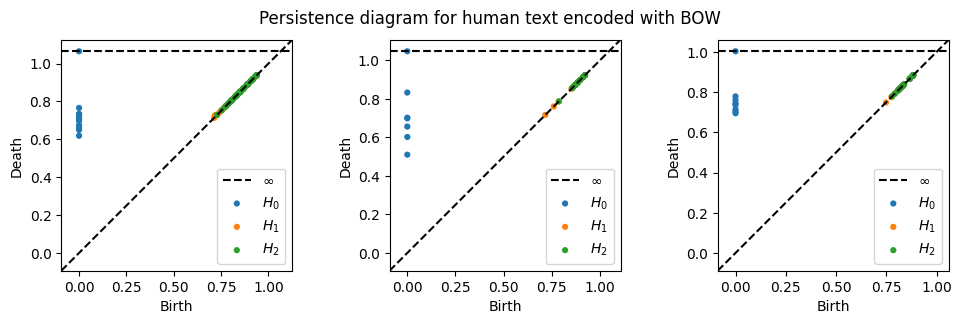

|H0|: 8.666666666666666 |H1|: 0.3333333333333333 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


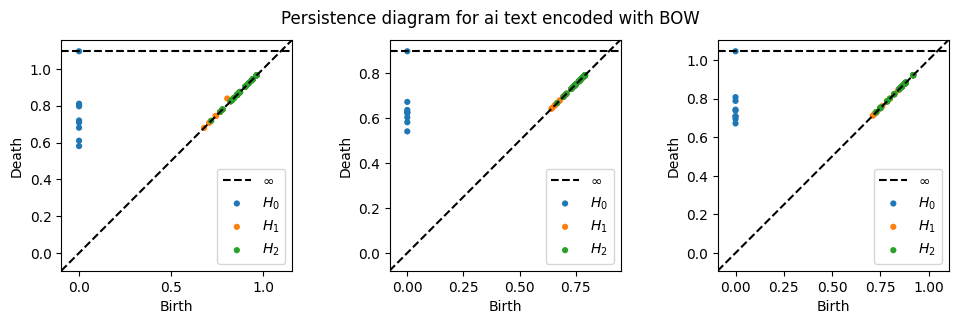

|H0|: 9.0 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


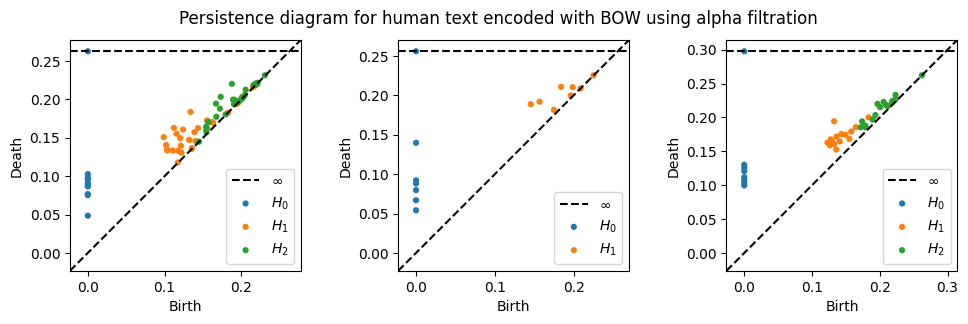

|H0|: 8.666666666666666 |H1|: 18.333333333333332 |H2|: 17.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


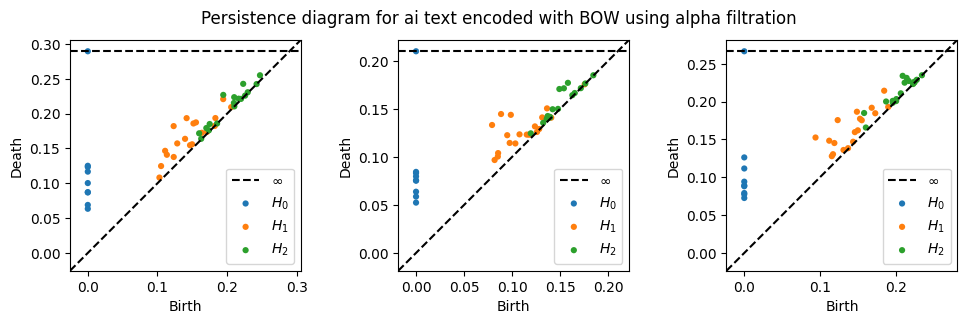

|H0|: 9.0 |H1|: 19.0 |H2|: 16.666666666666668
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


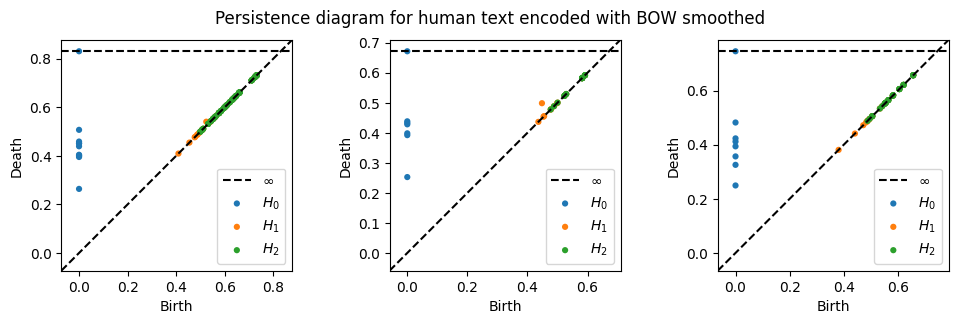

|H0|: 8.666666666666666 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


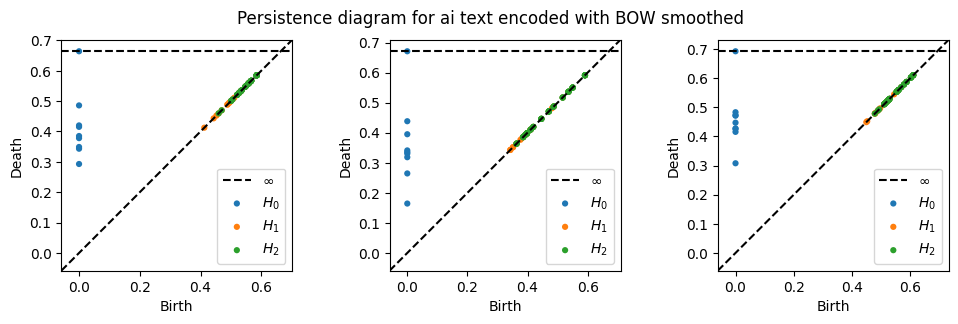

|H0|: 9.0 |H1|: 0.0 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


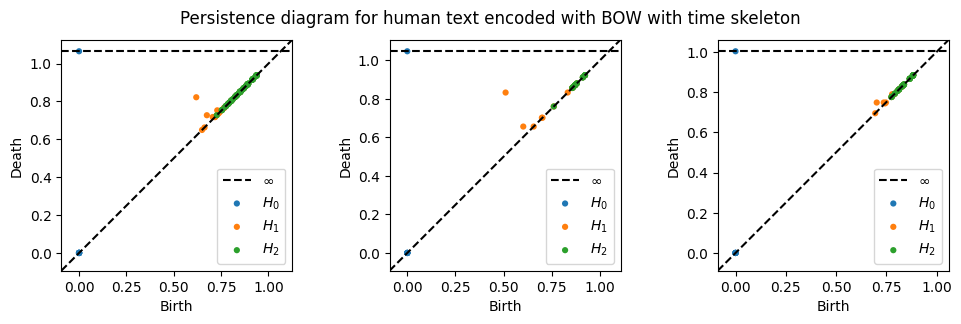

|H0|: 1.0 |H1|: 3.3333333333333335 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


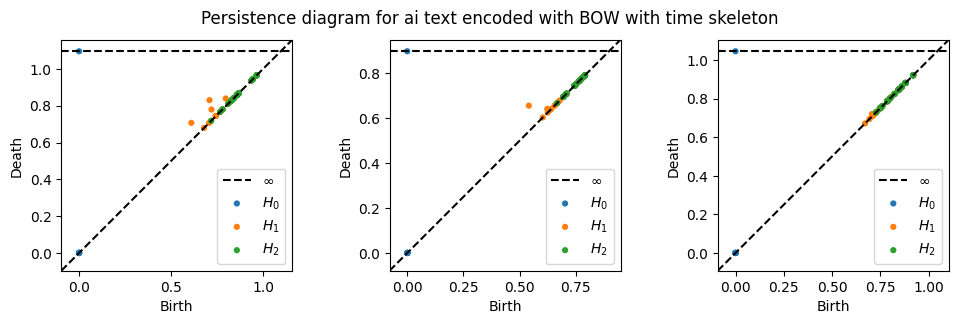

|H0|: 1.0 |H1|: 2.6666666666666665 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


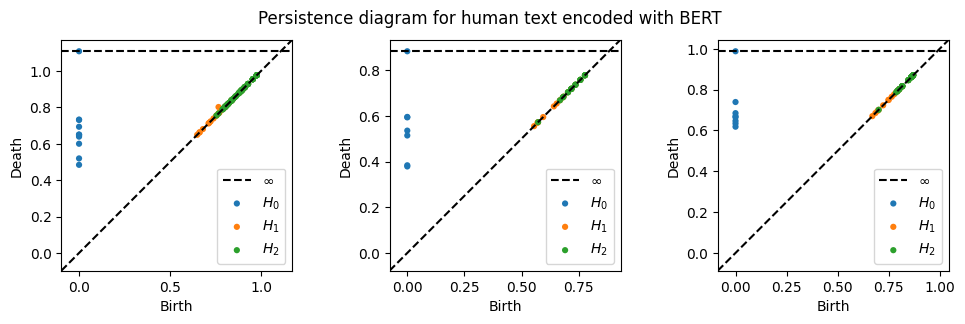

|H0|: 8.666666666666666 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


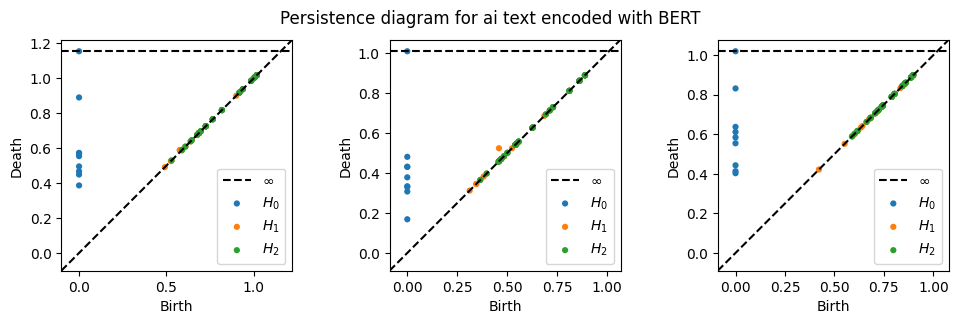

|H0|: 9.0 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


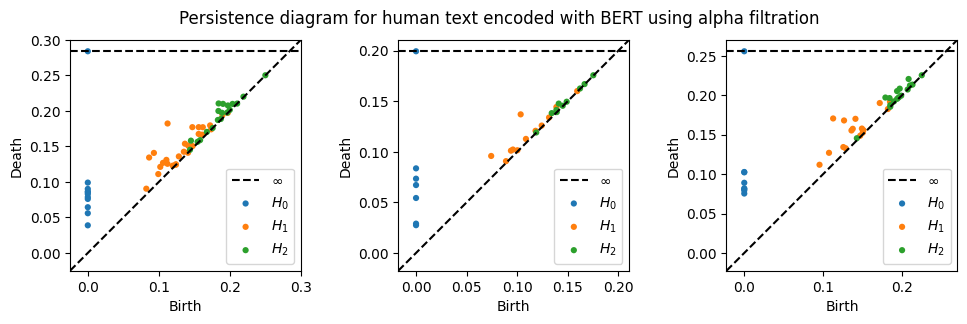

|H0|: 8.666666666666666 |H1|: 18.666666666666668 |H2|: 15.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


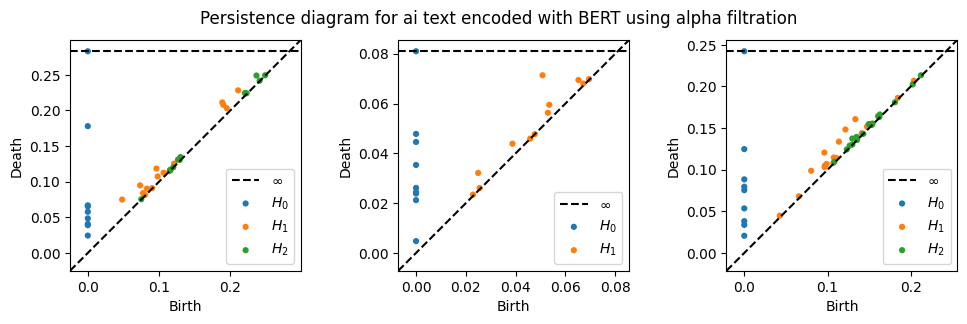

|H0|: 9.0 |H1|: 15.333333333333334 |H2|: 11.666666666666666
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


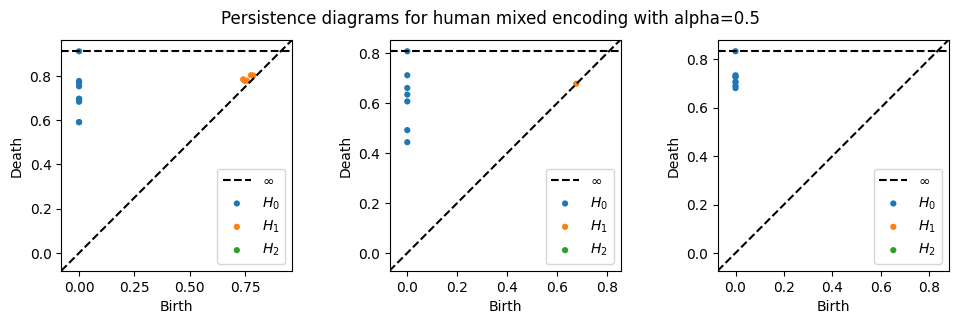

|H0|: 8.666666666666666 |H1|: 2.0 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


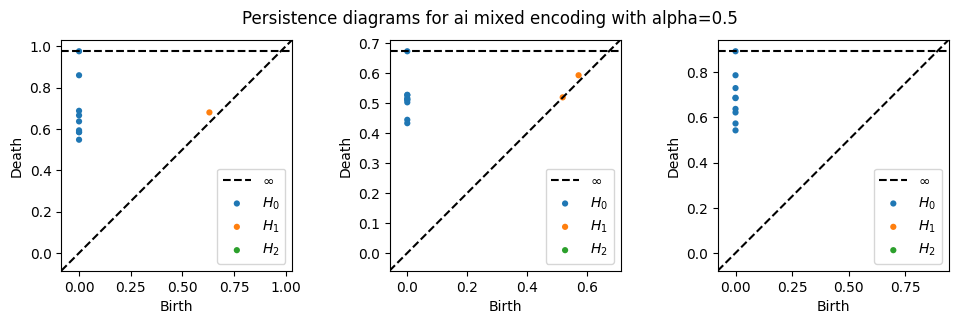

|H0|: 9.0 |H1|: 1.0 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


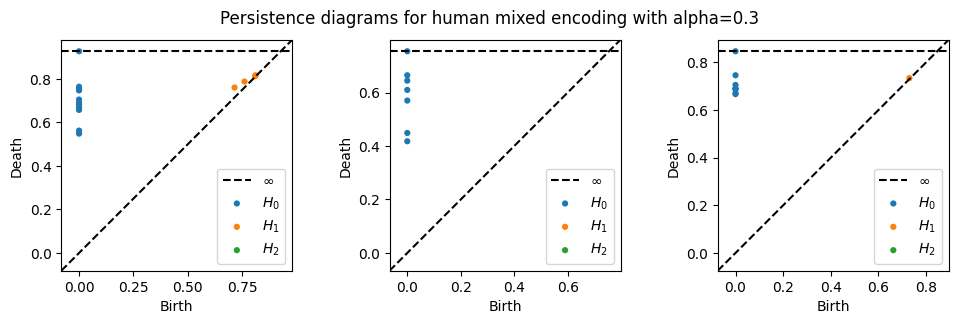

|H0|: 8.666666666666666 |H1|: 1.6666666666666667 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


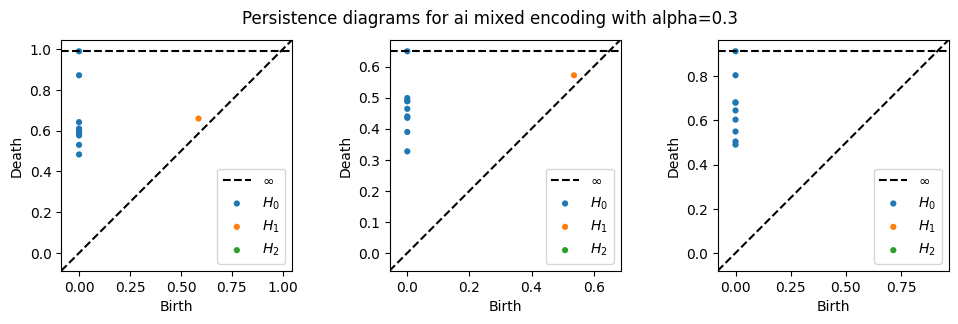

|H0|: 9.0 |H1|: 0.6666666666666666 |H2|: 0.0


In [18]:
run_evaluation('human', 'bow', graph=True);
run_evaluation('ai', 'bow', graph=True);
run_evaluation('human', 'bow', graph=True, filtration_type='alpha');
run_evaluation('ai', 'bow', graph=True, filtration_type='alpha');
run_evaluation('human', 'bow', with_smoothing=True, graph=True);
run_evaluation('ai', 'bow', with_smoothing=True, graph=True);
run_evaluation('human', 'bow', time_skeleton=True, graph=True);
run_evaluation('ai', 'bow', time_skeleton=True, graph=True);
run_evaluation('human', 'bert', graph=True);
run_evaluation('ai', 'bert', graph=True);
run_evaluation('human', 'bert', graph=True, filtration_type='alpha');
run_evaluation('ai', 'bert', graph=True, filtration_type='alpha');
run_mixed_encoding_evaluation('human', 0.5, graph=True);
run_mixed_encoding_evaluation('ai', 0.5, graph=True);
run_mixed_encoding_evaluation('human', 0.3, graph=True);
run_mixed_encoding_evaluation('ai', 0.3, graph=True);

In [20]:
evaluation('bow', time_skeleton=False, with_smoothing=False, num_abstracts=100)
print("")
evaluation('bow', time_skeleton=True, with_smoothing=False, num_abstracts=100)
print("")
evaluation('bert', time_skeleton=False, with_smoothing=False, num_abstracts=100)
print("")
#evaluation('bert', time_skeleton=True, with_smoothing=False, num_abstracts=100)
print("")
evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.5, num_abstracts=100)
print("")
evaluation('bert', filtration_type='alpha', num_abstracts=100)
print("")
evaluation('bow', filtration_type='alpha', num_abstracts=100)
print("")
#evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.3, num_abstracts=100)
print("")
#evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.8, num_abstracts=100)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text encoded with BOW
|H0|: 7.96 |H1|: 0.95 |H2|: 0.01
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text encoded with BOW
|H0|: 8.04 |H1|: 1.07 |H2|: 0.08
H0: classification success rate was 0.47761194029850745
H1: classification success rate was 0.4117647058823529
H2: classification success rate was 0.4117647058823529

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text encoded with BOW with time skeleton
|H0|: 0.83 |H1|: 2.82 |H2|: 0.12
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text encoded with BOW with time skeleton
|H0|: 0.84 |H1|: 2.79 |H2|: 0.13
H0: classification success rate was 0.47761194029850745
H1: classification success rate was 0.4117647058823529
H2: classification success rate was 0.4117647058823529

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False,